# Make ChatGPT-replica!!

230421, by wygo

#### 230421
- GPU 설정 후 모두실행 하면 STEP1~3까지 모두 돌아갈수있게 수정
- torch 1.x대 버전으로 다운
- RM모델 점수확인코드 추가

#### 230320
- ChatGPT는 공개 코드가 없습니다.
- 본 세미나에서는 ChatGPT를 만든 원리인 GPT fine-tuning, 강화학습(PPO), RLHF, ChatGPT 데이터셋 구축에 대해 다루고 코드 실습을 합니다.
- 만들어진 모델을 활용만 하는 건 재미없잖아요??
- 우리 분야만의 ChatGPT(한국어/전문분야)를 직접 만드는 방법을 소개합니다.
    - ※ 구현 모델은 ChatGPT-replica입니다. 실제 ChatGPT와 다를 수 있습니다.
    - ※ GPT3가 아닌 GPT2+RLHF로 구현합니다. 거대언어모델로 개발시 어려움이 있을 수 있습니다.
    - ※ 실습환경: Jupyter or Colab, 선수 지식: 파이썬


### Reference
- [code_TRL](https://github.com/lvwerra/trl)
- [code_Stanford Alpaca](https://github.com/tatsu-lab/stanford_alpaca)
- [code_Alpaca_lora](https://github.com/tloen/alpaca-lora)

- [blog_colossal-ai-chatgpt](https://www.hpc-ai.tech/blog/colossal-ai-chatgpt)
- [blog_RLHF_huggingface](https://huggingface.co/blog/rlhf)


### ChatGPT 학습 방법
- STEP 1) Prompt 라이브러리에서 샘플링하고 사람의 응답을 수집한 데이터를 사용하여 사전 학습된 대규모 언어 모델을 fine-tuning
- STEP 2) Prompt 라이브러리에서 샘플링하고, 대규모 언어 모델을 사용하여 여러 응답을 생성, 이러한 응답의 순위를 수동으로 지정하고, 인간의 선호도에 맞게 보상 모델(Reward Model)을 학습
- STEP 3) 1단계의 지도 미세 조정 모델과 2단계의 보상 모델을 기반으로 강화 학습 알고리즘을 사용하여 대규모 언어 모델을 추가로 훈련합니다.

###  ChatGPT 개발 Requirement
- 데이터(RLHF)
- LLM 모델(GPT3급)
- GPU
    - 수천 GB의 GPU 메모리가 필요
    - 일반적인 데이터 병렬 기술로도 X
    - 최소 64개의 80GB A100 GPU가 필요

###  ChatGPT-replica 실습 Requirement
- 데이터(RLHF): data_kochatgpt
- LLM 모델: GPT2
- GPU: Colab

### ChatGPT-replica 모델 정리
- [Step1_fine tuning code](https://github.com/philschmid/fine-tune-GPT-2/blob/master/Fine_tune_a_non_English_GPT_2_Model_with_Huggingface.ipynb)
- [huggingface_TRL](https://github.com/lvwerra/trl)
    - RL을 구현하기 위한 코드 제공
    - ChatGPT를 위해 코드수정이 많이많이 필요함
- [LLaMA](https://github.com/facebookresearch/llama)
    - ChatGPT보다 모델 크기가 작으면서도 성능이 좋은 모델 공개
    - 한국어..추가학습..
- [ChatLLaMA](https://github.com/juncongmoo/chatllama)
    - LLaMA를 Chat 형식으로 학습하도록 강화학습 코드 제공
    - GPT3기반 [대화 데이터셋 구축 코드](https://github.com/juncongmoo/chatllama/blob/main/generate_dataset.py) 제공, 수정 많이 필요 
- [Alpaca](https://github.com/tatsu-lab/stanford_alpaca)
    - Instruction 데이터 생성 및 SFT만

- [KoAlpaca](https://github.com/Beomi/KoAlpaca)
    - 한국어 Instruction 데이터 생성 및 SFT만

- [Alpaca-LoRA](https://github.com/tloen/alpaca-lora)
    - Low-Rank LLaMA Instruct-Tuning, SFT만

    
- **[ColossalAI](https://github.com/hpcaitech/ColossalAI/tree/main/applications/ChatGPT)**
    - step2 RM 학습과 step3 PPO 코드 깔끔하게 제공
    - Multi-GPU로 DDP, ColossalAIStrategy, LoRA 학습코드 제공!!
    
- **ColossalAI 장점**
    - ColossalAI는 pytorch에 비해 추론시 1.4배 빠르고, 학습시 7.7배 빠르다!!
    - ColossalAI는 pytorch와 비교해 10.3배 큰 모델을 처리할수 있다!!
    
<img src="https://raw.githubusercontent.com/hpcaitech/public_assets/main/applications/chatgpt/ChatGPT%20scaling.png" width="800">

<img src="https://raw.githubusercontent.com/hpcaitech/public_assets/main/applications/chatgpt/ChatGPT-1GPU.jpg" width="500">

### Step 0) Prepare RLHF dataset

- 총 3step을 학습하기 위해 3가지 데이터셋이 필요합니다.
- [데이터셋 예시](https://github.com/nebuly-ai/nebullvm/tree/main/apps/accelerate/chatllama#dataset-preparation)
- [예시 데이터셋 1](https://huggingface.co/datasets/stanfordnlp/SHP)
- [예시 데이터셋 2](https://huggingface.co/datasets/Anthropic/hh-rlhf)

step1) SFT(actor_training_data): SFT 지도 미세 조정에 사용되는 JSON 데이터
```json
[
    {
        "prompt": "",
        "completion": ""        
    }, ...
]
```

step2) RM 모델 학습용 데이터셋(reward_training_data): 보상 모델 학습에 사용되는 JSON 데이터셋. 한 prompt에 대해 여러 완성된 문장이 있고, 이 문장들의 ranking을 사람이 매김
```json
[
    {
        "prompt": "",
        "completion_1": "",
        "completion_2": "",
        "completion_3": "",            
        "ranking": [1, 0, 2]
    }, ...
]
```
    
step3) PPO 학습 입력 데이터셋(rlhf_training_data): RLHF 훈련에 사용되는 JSON 데이터셋, 사용자 입력 prompt로만 구성
```json
[
    {
        "prompt": ""
    }, ...
]
```

### step0) Colab 환경 설정

#### 설치(python>=3.8)
```python
## setup(1min)
# torch 버전 다운. torch>=2.0 에선 colosalai가 동작안함
!pip uninstall torch -y
!pip install torch==1.13.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

import torch

print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))
# for ColossalAI
!pip install colossalai==0.2.7

# setup data
!git clone https://github.com/airobotlab/KoChatGPT
!mv KoChatGPT/data_kochatgpt .
!mv KoChatGPT/img .

%cd KoChatGPT/colossalai_ChatGPT_230319/
!pip install .
%cd ../../

# setup library
!pip install openai
!pip install langchain==0.0.113
!pip install pandas>=1.4.1
```

In [1]:
import torch

print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))

Torch version:1.13.1
cuda version: 11.6
cudnn version:8302


In [9]:
# ## setup(1min)
# # torch 버전 다운. torch>=2.0 에선 colosalai가 동작안함
# !pip uninstall torch -y
# !pip install torch==1.13.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

# import torch

# print("Torch version:{}".format(torch.__version__))
# print("cuda version: {}".format(torch.version.cuda))
# print("cudnn version:{}".format(torch.backends.cudnn.version()))


# for ColossalAI
!pip install colossalai==0.2.7

# setup data
# !git clone https://github.com/airobotlab/KoChatGPT
# !mv KoChatGPT/data_kochatgpt .
# !mv KoChatGPT/img .

# %cd ./colossalai_ChatGPT_230319/
# !pip install .
# %cd ../../

# setup library
!pip install openai
!pip install langchain==0.0.113
!pip install pandas>=1.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.7/686.7 kB 10.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.5/202.5 kB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 kB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.2/211.2 kB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.2/593.2 kB 76.6 MB/s eta 0:00:00
     ━━━━━━━━

### Step 1) SFT: 질문에 대답을 잘하는 모델 만들기
- [fine tuning code_1](https://github.com/philschmid/fine-tune-GPT-2/blob/master/Fine_tune_a_non_English_GPT_2_Model_with_Huggingface.ipynb)
- [fine tuning code_2](https://github.com/Beomi/KoAlpaca/blob/main/train.py)

- SFT(Supervised Fine Tuning)
- Fine-tune a pretrained LLM on a specific domain or corpus of instructions and human demonstrations
- 기존 GPT3는 다음 단어를 잘 맞추는 모델. But 질문에 대해 답을 맞추는 모델이 X
- 질문에 응답을 잘하도록 SFT 수행
- 먼저 사람이 지시에 대한 대답을 직접 작성(데이터 13,000개)하고, 이 데이터셋으로 SFT
- 데이터: 질문-응답 쌍 데이터셋(12,000개)
- 예시)
    - 질문(prompt): 인공지능을 설명해보세요
    - 응답(completion): 인공지능은 인간의 학습능력, 추론능력, 지각능력을 인공적으로 구현하려는 컴퓨터 과학의 세부분야 중 하나이다. ...  


- **SFT 예시**  
<img src="img/1_SFT_1.png" width="500">  

- **모델 입출력 예시**  
<img src="img/image_step1.JPG" width="500">  

- **전체 구조**  
<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/rlhf/pretraining.png" width="500">

- **데잍어셋 형태**
step1) SFT(actor_training_data): SFT 지도 미세 조정에 사용되는 JSON 데이터
```json
[
    {
        "prompt": "",
        "completion": ""        
    }, ...
]
```

- **결과물**
    - Before: 다음 단어만 잘 생성 했었음
    - After: 질문에 ‘잘’ 대답하는 모델
    


In [ ]:
    '/workspace/kogpt/kogpt-ft-3',
    "kakaobrain/kogpt",

In [1]:
# import
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments, AutoModelWithLMHead
from copy import deepcopy
from torch.optim import Adam
from transformers import AutoTokenizer, BloomTokenizerFast
from transformers.models.gpt2.tokenization_gpt2 import GPT2Tokenizer
import pandas as pd
import argparse
import copy
import logging
import json
from dataclasses import dataclass, field

def safe_save_model_for_hf_trainer(trainer: transformers.Trainer, output_dir: str):
    """Collects the state dict and dump to disk."""
    state_dict = trainer.model.state_dict()
    if trainer.args.should_save:
        cpu_state_dict = {key: value.cpu() for key, value in list(state_dict.items())}
        del state_dict
        trainer._save(output_dir, state_dict=cpu_state_dict)  # noqa

In [2]:
# define argment
parser = argparse.ArgumentParser()
parser.add_argument('--data_path_1_SFT', type=str, default='./data_kochatgpt/kochatgpt_1_SFT.jsonl')
parser.add_argument('--model_name', type=str, default='kogpt')
parser.add_argument('--max_epochs', type=int, default=2)
parser.add_argument('--train_batch_size', type=int, default=8)
parser.add_argument('--output_dir', type=str, default='./output_1_SFT-kogpt')

args = parser.parse_args(args=[])

# for test
args.model_name = '/workspace/kogpt/kogpt-ft-3',

args.max_epochs = 2

print(args)

Namespace(data_path_1_SFT='./data_kochatgpt/kochatgpt_1_SFT.jsonl', model_name=('/workspace/kogpt/kogpt-ft-3',), max_epochs=2, train_batch_size=8, output_dir='./output_1_SFT-kogpt')


In [3]:
## test & load skt gpt2 kroean
import torch
from transformers import GPT2LMHeadModel

from transformers import PreTrainedTokenizerFast
tokenizer = transformers.AutoTokenizer.from_pretrained(
        "kakaobrain/kogpt",
        revision="KoGPT6B-ryan1.5b-float16",  # or float32 version: revision=KoGPT6B-ryan1.5b
        bos_token="[BOS]",
        eos_token="[EOS]",
        unk_token="[UNK]",
        pad_token="[PAD]",
        mask_token="[MASK]",
        model_max_length=512
    )
print(tokenizer.tokenize("안녕하세요. 한국어 GPT-2 입니다.😤:)l^o"))
# ['▁안녕', '하', '세', '요.', '▁한국어', '▁G', 'P', 'T', '-2', '▁입', '니다.', '😤', ':)', 'l^o']


model = transformers.AutoModelForCausalLM.from_pretrained(
#     './kogpt-ft-3',
    "kakaobrain/kogpt",
    revision="KoGPT6B-ryan1.5b-float16",  # or float32 version: revision=KoGPT6B-ryan1.5b
    pad_token_id=tokenizer.pad_token_id,
    torch_dtype=torch.float16,
    # torch_dtype='auto',
    low_cpu_mem_usage=True,
).to('cuda')

['ìķĪëħķ', 'íķĺ', 'ìĦ¸ìļĶ', '.', 'ĠíķľêµŃìĸ´', 'ĠGP', 'T', '-', '2', 'ĠìŀħëĭĪëĭ¤', '.', '😤', ':)', 'l^o']


In [4]:
text = '근육이 커지기 위해서는'
input_ids = tokenizer.encode(text, return_tensors='pt').to('cuda')
gen_ids = model.generate(input_ids,
                         max_length=256,
                         repetition_penalty=2.0,
                         pad_token_id=tokenizer.pad_token_id,
                         eos_token_id=tokenizer.eos_token_id,
                         bos_token_id=tokenizer.bos_token_id,
                         use_cache=True)
generated = tokenizer.decode(gen_ids[0])
print(generated)


# generator = pipeline("text-generation", model=model, tokenizer=tokenizer, device='cuda:0')
# generation_args = dict(
#     num_beams=4,
#     repetition_penalty=2.0,
#     no_repeat_ngram_size=4,
#     eos_token_id=375, # \n
#     max_new_tokens=64,
#     do_sample=True,
#     top_k=50,
#     early_stopping=True
# )
# generator(
#     ["0 : **는 게임 좋아하니\n1 :",
#     "0 : 어제 강남에서 살인사건 났대 ㅜㅜ 너무 무서워\n1 : 헐 왜? 무슨 일 있었어?\n0 : 사진보니까 막 피흘리는 사람있고 경찰들이 떠서 제압하고 난리도 아니었다던데??\n1 :",
#     "0 : 자기야 어제는 나한테 왜 그랬어?\n1 : 뭔 일 있었어?\n0 : 어떻게 나한테 말도 없이 그럴 수 있어? 나 진짜 실망했어\n1 : "],
#     **generation_args
# )

근육이 커지기 위해서는 근육에 지속적인 자극(stimulation)을 주어야 한다. 즉, 근력 운동은 근섬유를 손상시키고 그 후 회복되어 원상태로 돌아가는데 필요한 시간보다 더 많 은 기간 동안 반복적으로 수행해야만 효과가 있다"라고 강조했습니다.. 또한 "근력운동의 목적인 '최대산소섭취량' 증가와 같 이 중요하게 생각할 것들이 몇 가지있는데요~ 첫째! 유산소성 능력 향상 둘째!! 체지방 감소 셋째!!! 관절 건강 유지 넷째!!!! 유연성과 균형감각 증진 다섯째!!!!!!!! 심폐지구 력과 폐활량의 개선 여섯째????? 신체구성 변화입니다...^^ 위에서도 언급 했듯이 최대 산소 섭취량도 매우중요하지만 그것만큼이나 또 다른 요소들 도 고려해주셔야 합니다.... 그리고 마지막 여섯번째까지 가서 가장 크 게 신경써주시면 좋으실 부분인데요~~ 바로 체성분변화 입니다........체 성분이란 지방조직 + 단백질 조직 으로 구성된것인데 이것들의 비율 (% body fat mass / 체중kg당 부피 kg/m3 등 을 말합니다 ^^; 쉽죠??ᄏ ) 에 따라 몸매나 몸짱 여부등 여러가지 결과 를 볼 수 잇답니다 ᄒ 그렇다면 어떻게 해야


In [5]:
# data config
IGNORE_INDEX = -100
# DEFAULT_PAD_TOKEN = "[PAD]"
# DEFAULT_EOS_TOKEN = "</s>"
# DEFAULT_BOS_TOKEN = "</s>"
# DEFAULT_UNK_TOKEN = "</s>"
PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context.\n\n"
        "Write a detailed response that appropriately completes the request.\n\n"\
        "### Instruction:\n{prompt}\n\n### Input:\n{input}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task.\n\n"
        "Write a detailed response that appropriately completes the request.\n\n"
        "### Instruction:\n{prompt}\n\n### Response:"
    ),
}

In [6]:
# ## 모델 준비
# model = AutoModelForCausalLM.from_pretrained(args.model_name).to('cuda')
# tokenizer = transformers.AutoTokenizer.from_pretrained(
#     args.model_name,
#     padding_side="right",
#     model_max_length=512,    
# )
# tokenizer.add_special_tokens(
#     {
#         "eos_token": DEFAULT_EOS_TOKEN,
#         "bos_token": DEFAULT_BOS_TOKEN,
#         "unk_token": DEFAULT_UNK_TOKEN,
#     }
# )    
# tokenizer.pad_token = tokenizer.eos_token
# print(tokenizer)

In [6]:
## prepare data
from typing import Optional, Dict, Sequence
    
class SFT_dataset(Dataset):
    '''SFT dataset by wygo'''
    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")
        
        ## format
        pattern_instruction = 'prompt'  # instruction
        pattern_input = 'input'  # 내 데이터엔 input이 없다
        pattern_output = 'completion'  # output

        ############################################################
        ## load dataset
        # 내 데이터셋엔 input이 없다
#         data_path_1_SFT = 'data_kochatgpt/korean_chatgpt_1_SFT.jsonl'
        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)
            if verbose:
                print('## data check ##')
                print((list_data_dict[0]))
        # {'prompt': '불고기용 고기 한우에요?',
        #  'completion': "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
        #  'tokens': 193}        

        ############################################################
        ## 데이터셋 만들기, source와 target
        prompt_input, prompt_no_input = PROMPT_DICT["prompt_input"], PROMPT_DICT["prompt_no_input"]  # 템플릿 가져오기

        # 입력
        sources = []
        for example in list_data_dict:
            if example.get(pattern_input, "") != "":
                tmp = prompt_input.format_map(example)
            else:
                tmp = prompt_no_input.format_map(example)
            sources.append(tmp)

        # 출력
        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")

        if verbose:
            idx = 0
            print((sources[idx]))
            print((targets[idx]))
            print("Tokenizing inputs... This may take some time...")

        ############################################################
        # data_dict = preprocess(sources, targets, tokenizer)  # https://github.com/Beomi/KoAlpaca/blob/04704348d58b8b1c2e2638d6437a04b4e8ba1823/train.py#L124
        examples = [s + t for s, t in zip(sources, targets)]

        # source data tokenized
        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source만
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target


        ## 입력은 source, 출력은 source+target 이지만 학습은 target 부분만
        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = IGNORE_INDEX  # source 부분은 -100으로 채운다

        data_dict = dict(input_ids=input_ids, labels=labels)        
        
        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))    
        
    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        """Tokenize a list of strings."""
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )        
        
        
    def __len__(self):
        return len(self.input_ids)

    
    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])


@dataclass
class DataCollatorForSupervisedDataset(object):
    """Collate examples for supervised fine-tuning."""

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=IGNORE_INDEX)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

    

train_dataset = SFT_dataset(data_path_1_SFT=args.data_path_1_SFT, tokenizer=tokenizer)
eval_dataset  = None  # eval은 안함
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

# check
# print('input : %s'%train_dataset.input_ids[0])
# print('output: %s'%train_dataset.labels[0])

In [7]:
## 학습 (10min)
# training_args 수정 가능: https://github.com/Beomi/KoAlpaca/blob/main/train.sh 참고
training_args = TrainingArguments(
    output_dir="./test", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=1, # number of training epochs
    per_device_train_batch_size=1, # batch size for training
    gradient_accumulation_steps=8,
#     per_device_eval_batch_size=1,  # batch size for evaluation
#     eval_steps = 3, # Number of update steps between two evaluations.
    save_steps=1000, # after # steps model is saved 
    save_total_limit = 1,
    warmup_steps=5,# number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    optim='adafactor',
    report_to='none'
    )
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

trainer.train()
# trainer.save_state()
# safe_save_model_for_hf_trainer(trainer=trainer, output_dir=args.output_dir)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:26                                                                                   │
│                                                                                                  │
│   23 │   eval_dataset=eval_dataset,                                                              │
│   24 )                                                                                           │
│   25                                                                                             │
│ ❱ 26 trainer.train()                                                                             │
│   27 # trainer.save_state()                                                                      │
│   28 # safe_save_model_for_hf_trainer(trainer=trainer, output_dir=args.output_dir)               │
│   29                                                                                             │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:1662 in train                    │
│                                                                                                  │
│   1659 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1660 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1661 │   │   )                                                                                 │
│ ❱ 1662 │   │   return inner_training_loop(                                                       │
│   1663 │   │   │   args=args,                                                                    │
│   1664 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1665 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:1929 in _inner_training_loop     │
│                                                                                                  │
│   1926 │   │   │   │   │   with model.no_sync():                                                 │
│   1927 │   │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                  │
│   1928 │   │   │   │   else:                                                                     │
│ ❱ 1929 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1930 │   │   │   │                                                                             │
│   1931 │   │   │   │   if (                                                                      │
│   1932 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:2717 in training_step            │
│                                                                                                  │
│   2714 │   │   │   # loss gets scaled under gradient_accumulation_steps in deepspeed             │
│   2715 │   │   │   loss = self.deepspeed.backward(loss)                                          │
│   2716 │   │   else:                                                                             │
│ ❱ 2717 │   │   │   loss.backward()                                                               │
│   2718 │   │                                                                                     │
│   2719 │   │   return loss.detach()                                                              │
│   2720                                                     

In [23]:
args.output_dir

'./output_1_SFT'

In [24]:
## 추론 테스트
generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device='cuda:0')
# generator = pipeline('text-generation', model=model.cpu(), tokenizer=tokenizer, config={'max_length':800})

generation_args = dict(
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어',
               '오늘 미세먼지 어때?']
list_prompt = [PROMPT_DICT['prompt_no_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)
for prompt, result in zip(list_prompt, list_result):
    print(('#'*70))
    print(('completion: %s'%(result[0]['generated_text'])))

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


######################################################################
completion: Below is an instruction that describes a task.
아래는 작업을 설명하는 명령어입니다.

Write a response that appropriately completes the request.
명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.

### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 AI 어시스턴트이기 때문에 실제로 불고기를 먹을 수 없습니다. 하지만 일반적으로 불고기용 고기는 건강에 좋은 식품 중 하나입니다. 따라서 건강한 식습관을 유지하는 것이 좋습니다.\n\n따라서 어떤 종류의 불고기를 원하시는지 알려주시면 더 정확한 답변을
######################################################################
completion: Below is an instruction that describes a task.
아래는 작업을 설명하는 명령어입니다.

Write a response that appropriately completes the request.
명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 47대 부통령직을 수행했습니다. Canadd of Johnson. There are personal service, but I can assist you would you like to provide more context or
######################################################################
completion: Below is an instruction th

In [10]:
torch.cuda.empty_cache() 

#### GPT2 모델이 사람의 질문에 대해 **'잘'** 대답하는 모델을 학습했습니다.  
#### ``output_1_SFT`` 폴더에 학습된 모델이 저장되어 있습니다.  
#### 이제 step2) RM 보상모델을 학습해 볼까요??

### 2) RM: 좋은 글 채점기 만들기
- Collect a human annotated dataset and train a reward model
- **배경**
    - 기존 AI는 주관적인 글을 채점(점수화) 할 수 없었음
    - 사람이 직접 피드백을 줘서 글 채점의 척도로 사용하자
    - 매번 사람이 채점할 수 없으니, 사람의 채점을 모방하는 **좋은글 채점 AI모델** 을 만들자

    - 채점 AI모델을 만드려면, 사람이 글을 채점한 데이터셋(33,000개)이 필요하다
    - 동일 질문에 대해 AI모델이 생성한 여러 글(한 번에 4~6개 세트)을 사람이 직접 ranking을 매긴다.
    - 왜?? 사람이 생성한 글에 바로 점수를 매기게 되면 사람마다 기준이 다를 수 있기 때문에 순위로
    - **C > B > A**  

- **Human labeling 예시**
<img src="img/2_RM_1.png" width="700">  


- **좋은글 채점 모델 학습(RM, Reward Model)**
    - 1등 글은 높은 점수를
    - 꼴등 데이터는 낮은 점수를
    - 입력: AI가 생성한 글
    - 출력: 0~1점  


- 보상모델 입출력
<img src="img/2_RM_2.png" width="700">

- **결과물**
    - Before: 좋은 글, 나쁜 글 판단 불가능
    - After: 사람이 읽기에 좋은글/나쁜글 판단 모델
    
    
- **전체 구조**
<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/rlhf/reward-model.png" width="500">

##### Step 2) Train the reward model
-[ref](https://github.com/hpcaitech/ColossalAI/blob/main/applications/ChatGPT/examples/train_reward_model.py)

We use rm-static as dataset to train our reward model.
It is a dataset of chosen & rejected response of the same prompt.
You can download the dataset from huggingface automatically.
Use these code to train your reward model.

##### Naive reward model training
python train_reward_model.py --pretrain <your model path>

##### if to use LoRA
python train_reward_model.py --pretrain <your model path> --lora_rank 16

In [11]:
# ## setup(1min)
# # torch 버전 다운. torch>=2.0 에선 colosalai가 동작안함
# !pip uninstall torch -y
# !pip install torch==1.13.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

# import torch

# print("Torch version:{}".format(torch.__version__))
# print("cuda version: {}".format(torch.version.cuda))
# print("cudnn version:{}".format(torch.backends.cudnn.version()))

# # for ColossalAI
# !pip install colossalai==0.2.7

# # setup data
# !git clone https://github.com/airobotlab/KoChatGPT
# !mv KoChatGPT/data_kochatgpt .
# !mv KoChatGPT/img .

# %cd KoChatGPT/colossalai_ChatGPT_230319/
# !pip install .
# %cd ../../

In [1]:
# import
import argparse

import loralib as lora
import torch
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.models.bloom import BLOOMRM
from chatgpt.models.gpt import GPTRM
from chatgpt.models.opt import OPTRM
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import ColossalAIStrategy, DDPStrategy, NaiveStrategy
from datasets import load_dataset
from torch.optim import Adam
from transformers import AutoTokenizer, BloomTokenizerFast
from transformers.models.gpt2.tokenization_gpt2 import GPT2Tokenizer

from colossalai.nn.optimizer import HybridAdam

import os
import json

# data config
IGNORE_INDEX = -100
DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "</s>"
DEFAULT_UNK_TOKEN = "</s>"
PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context.\n"
        "아래는 작업을 설명하는 명령어와 추가적 맥락을 제공하는 입력이 짝을 이루는 예제입니다.\n\n"
        "Write a response that appropriately completes the request.\n요청을 적절히 완료하는 응답을 작성하세요.\n\n"
        "### Instruction(명령어):\n{prompt}\n\n### Input(입력):\n{input}\n\n### Response(응답):"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task.\n"
        "아래는 작업을 설명하는 명령어입니다.\n\n"
        "Write a response that appropriately completes the request.\n명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.\n\n"
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    ),
}

/opt/conda/lib/python3.10/site-packages/torch/library.py:130: UserWarning: Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: aten::index.Tensor(Tensor self, Tensor?[] indices) -> Tensor
    registered at aten/src/ATen/RegisterSchema.cpp:6
  dispatch key: Meta
  previous kernel: registered at ../aten/src/ATen/functorch/BatchRulesScatterOps.cpp:1053
       new kernel: registered at /dev/null:241 (Triggered internally at ../aten/src/ATen/core/dispatch/OperatorEntry.cpp:150.)
  self.m.impl(name, dispatch_key, fn)


In [29]:
# define argment
parser = argparse.ArgumentParser()
parser.add_argument('--output_dir', type=str, default='./output_2_RM')
parser.add_argument('--data_path_2_RM', type=str, default='./data_kochatgpt/kochatgpt_2_RM.jsonl', help='https://huggingface.co/datasets/fka/awesome-chatgpt-prompts/blob/main/prompts.csv')
parser.add_argument('--strategy',
                    choices=['naive', 'ddp', 'colossalai_gemini', 'colossalai_zero2'],
                    default='naive')
parser.add_argument('--model', type=str, default='gpt2', choices=['gpt2', 'bloom', 'opt'])
parser.add_argument('--pretrain_model', type=str, default=None)
parser.add_argument('--pretrain_tokenizer', type=str, default=None)
parser.add_argument('--dataset', type=str, default='Dahoas/rm-static')
parser.add_argument('--save_path', type=str, default='rm_ckpt.pth')
parser.add_argument('--max_epochs', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=4)
parser.add_argument('--lora_rank', type=int, default=0, help="low-rank adaptation matrices rank")
parser.add_argument('--max_len', type=int, default=512)  # wygo 추가

args = parser.parse_args(args=[])

# for test
args.max_epochs = 3
args.pretrain_tokenizer = 'skt/kogpt2-base-v2'  # pretrained 토크나이저 가져오기
# args.pretrain_model = 'skt/kogpt2-base-v2'  # pretrained 모델 가져오기
args.pretrain_model = './output_1_SFT'  # pretrained 모델 가져오기 (sft 그대로 써야 함)
args.verbose = True

print(args)
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

Namespace(output_dir='./output_2_RM', data_path_2_RM='./data_kochatgpt/kochatgpt_2_RM.jsonl', strategy='naive', model='gpt2', pretrain_model='./output_1_SFT', pretrain_tokenizer='skt/kogpt2-base-v2', dataset='Dahoas/rm-static', save_path='rm_ckpt.pth', max_epochs=3, batch_size=4, lora_rank=0, max_len=512, verbose=True)


In [30]:
# configure strategy
if args.strategy == 'naive':
    strategy = NaiveStrategy()
elif args.strategy == 'ddp':
    strategy = DDPStrategy()
elif args.strategy == 'colossalai_gemini':
    strategy = ColossalAIStrategy(stage=3, placement_policy='cuda')
elif args.strategy == 'colossalai_zero2':
    strategy = ColossalAIStrategy(stage=2, placement_policy='cuda')
else:
    raise ValueError(f'Unsupported strategy "{args.strategy}"')

In [31]:
# customizing, https://github.com/hpcaitech/ColossalAI/blob/2e16f842a9e5b1fb54e7e41070e9d2bb5cd64d7c/applications/ChatGPT/chatgpt/nn/gpt_rm.py#L29
from typing import Optional

import torch.nn as nn
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model

# from ..base import RewardModel
from chatgpt.models.base import RewardModel


class GPTRM_custom(RewardModel):
    """
    GPT Reward model.
    Args:
        pretrained (str): Pretrained model name or path.
        config (GPT2Config): Model config.
        checkpoint (bool): Enable gradient checkpointing.
        lora_rank (int): Rank of the low-rank approximation.
        lora_train_bias (str): LoRA bias training mode.
    """

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))  # wygo 추가!!!
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        
        # model = model.resize_token_embeddings(len(tokenizer))

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        # 추가, 230421    
        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained
        
    # 추가, 230421, config.json을 생성하기 위해 추가
    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

In [32]:
# configure model, tokenizer
with strategy.model_init_context():
    # load pretrained gpt2    
    if args.model == 'gpt2':
        tokenizer = AutoTokenizer.from_pretrained(args.pretrain_tokenizer, padding_side="right", model_max_length=512)
        tokenizer.add_special_tokens(
            {
                "eos_token": DEFAULT_EOS_TOKEN,
                "bos_token": DEFAULT_BOS_TOKEN,
                "unk_token": DEFAULT_UNK_TOKEN,
            }
        )
        tokenizer.pad_token = tokenizer.eos_token
        model = GPTRM_custom(pretrained=args.pretrain_model, lora_rank=args.lora_rank, tokenizer=tokenizer).cuda()

    elif args.model == 'bloom':
        model = BLOOMRM(pretrained=args.pretrain_model, lora_rank=args.lora_rank).cuda()
        tokenizer = BloomTokenizerFast.from_pretrained(args.pretrain_tokenizer)
    
    elif args.model == 'opt':
        model = OPTRM(pretrained=args.pretrain_model, lora_rank=args.lora_rank).cuda()
        tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")      
    
    else:
        raise ValueError(f'Unsupported model "{args.model}"')
    
    
    # model.resize_token_embeddings(len(tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at ./output_1_SFT were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
# make ranking data to chosen, rejetced data
with open(args.data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    
    # lsw add
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]
    list_prompt = [PROMPT_DICT['prompt_no_input'].format_map({'prompt': tmp}) for tmp in list_prompt]
    for x,y in zip(list_data_dict, list_prompt):
        x.update({'prompt':y})

    if args.verbose:
        print('## data check ##')
        print((list_data_dict[0]))
        
total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    # data 1) 0 VS 1
    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)


    # data 2) 0 VS 2
    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    # data 1) 1 VS 2
    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)
    
    
    
    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

## data check ##
{'prompt': 'Below is an instruction that describes a task.\n아래는 작업을 설명하는 명령어입니다.\n\nWrite a response that appropriately completes the request.\n명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.\n\n### Instruction(명령어):\n번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?\n\n### Response(응답):', 'completion_0': 'Allow me to answer your question. I know that you are curious about me.', 'completion_1': '번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.', 'completion_2': '라이언에게 말했다.', 'ranking': [2, 1, 0]}
before data num: 10220
after  data num: 30660
data example: 
{'prompt': 'Below is an instruction that describes a task.\n아래는 작업을 설명하는 명령어입니다.\n\nWrite a response that appropriately completes the request.\n명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.\n\n### Instruction(명령어):\n애플은 리사를 어떻게 처리했어\n\n### Response(응답):', 'chosen': '애플이 누구인지 명확히 알 수 없어서, 리사가 누구인지와 어떤 상황에서 처리되었는지에 대한 추가적인 정보가 필요합니다. 따라서, 보다 정확한 답변을 제공할 수 없습니다.', 'rejected': '애플은 리사를 위해 고객 서비스 부서에서 고객 다양한 컴퓨터 관련 문제에 대해 응답하는 데 필요한 모든 지원을 제공했습니다. 사용자가 

In [34]:
# prepare for data and dataset
import random
random.seed(230319)
# list_tmp = list(range(10))
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

# train_data = total_data_ranking2chosen[:-1000]  # 29000 학습
# eval_data = total_data_ranking2chosen[-1000:0]  # 1000개만 평가

train_data = total_data_ranking2chosen[:100]  # 29000 학습
eval_data = total_data_ranking2chosen[100:130]  # 1000개만 평가


train_dataset = RewardDataset(train_data, tokenizer, args.max_len)
eval_dataset = RewardDataset(eval_data, tokenizer, args.max_len)

# check
idx = 10
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

{'prompt': 'Below is an instruction that describes a task.\n아래는 작업을 설명하는 명령어입니다.\n\nWrite a response that appropriately completes the request.\n명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.\n\n### Instruction(명령어):\n유아인이 류승완 감독을 만나 영화 베테랑의 시나리오를 받았던 곳은?\n\n### Response(응답):', 'chosen': '유아인이 류승완 감독을 만나 영화 베테랑의 시나리오를 받았던 곳은 류승완의 사무실입니다.', 'rejected': '대구 영화사옥'}


100%|██████████| 30/30 [00:00<00:00, 1372.02it/s]

######################################################################
## prompt ##
Below is an instruction that describes a task.
아래는 작업을 설명하는 명령어입니다.

Write a response that appropriately completes the request.
명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.

### Instruction(명령어):
체크인 되나요?

### Response(응답):
######################################################################
## chosen ##
제가 AI 챗봇이기 때문에 호텔이나 항공편 등으로 어떤 체크인을 말씀하시는 것인지 구체적으로 설명해주시면 답변을 드리겠습니다.
######################################################################
## rejected ##
다시 한번 가지게임이지 않아 가지게임이지


In [35]:
# configure optimizer
if args.strategy.startswith('colossalai'):
    optim = HybridAdam(model.parameters(), lr=5e-5)
else:
    optim = Adam(model.parameters(), lr=5e-5)

In [36]:
# batch_size here is expected to be C(k,2), k means # response of each prompt
# be limited with the format of dataset 'Dahoas/rm-static', we'd better use batch_size as 1
trainer = RewardModelTrainer(model=model,
                             strategy=strategy,
                             optim=optim,
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=args.batch_size,
                             max_epochs=args.max_epochs)

###### 참고
- [train reward model](https://github.com/hpcaitech/ColossalAI/blob/2e16f842a9e5b1fb54e7e41070e9d2bb5cd64d7c/applications/ChatGPT/chatgpt/trainer/rm.py#L68)

In [37]:
# train!!
trainer.fit(use_lora=args.lora_rank)

## save
# save model checkpoint after fitting on only rank0
strategy.save_model(model, os.path.join(args.output_dir, 'RM.pt'), only_rank0=True)
# save optimizer checkpoint on all ranks
strategy.save_optimizer(optim,
                        os.path.join(args.output_dir, 'RM_optim_checkpoint_%d.pt' % (torch.cuda.current_device())),
                        only_rank0=False)

model.save_pretrained(args.output_dir)  # config.json 생성

Train step of epoch 0: 100%|██████████| 25/25 [00:08<00:00,  2.92it/s, loss=0.596, dist_mean=0.282]

Train step of epoch 1: 100%|██████████| 25/25 [00:07<00:00,  3.18it/s, loss=0.508, dist_mean=0.715]

Train epoch: 100%|██████████| 3/3 [00:24<00:00,  8.11s/it]


In [38]:
# 보상모델 체크
def inference_RM(input_text='인공지능은 인공지능 입니다'):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]
    
    print('input: %s\nreward score: %.1f'%(input_text, output_reward))
    
    return output_reward


input_text = '한국은 대한민국 입니다'
# input_text = '인공지능은 인공지능 입니다'

output_reward = inference_RM(input_text=input_text)

input: 한국은 대한민국 입니다
reward score: -8.1


In [39]:
torch.cuda.empty_cache()

#### 사람의 선호도를 모방한 좋은 글 채점기 모델을 학습했습니다.  
#### ``output_2_RM`` 폴더에 학습된 모델이 저장되어 있습니다.  
#### 이제 step3) PPO 모델을 학습해볼까요?

### Step 3) 사람의 피드백을 반영하여 학습

- Further fine-tune the LLM from step 1 with the reward model and this dataset using RL (e.g. PPO)
- 배경
    - **사람의 순위를 모사한 보상모델(RM)** 의 점수가 높아지도록 학습 (31,000개)
    - 초기 모델에 비해 너무 많이 바뀌지 않도록  
    
    
    
<img src="./img/3_PPO_1.png" width="650">
    

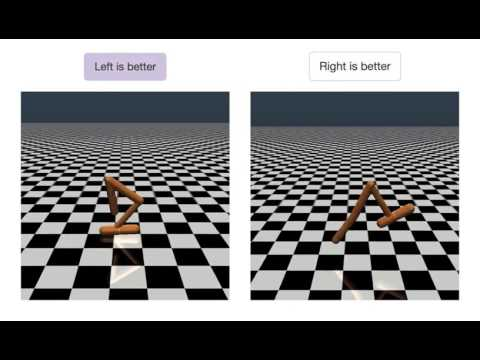

In [22]:
# Human Feedback RL
from IPython.display import YouTubeVideo
YouTubeVideo('oC7Cw3fu3gU')

##### RLHF
- [train_dummy](https://github.com/hpcaitech/ColossalAI/blob/main/applications/ChatGPT/examples/train_dummy.py)
- [train_prompts](https://github.com/hpcaitech/ColossalAI/blob/main/applications/ChatGPT/examples/train_prompts.py)
- [좋은설명](https://gist.github.com/JoaoLages/c6f2dfd13d2484aa8bb0b2d567fbf093)

- [dataset1](https://huggingface.co/datasets/Dahoas/rm-static)
- [dataset2](https://huggingface.co/datasets/Anthropic/hh-rlhf)

<img src="https://raw.githubusercontent.com/hpcaitech/public_assets/main/applications/chatgpt/chatgpt.png" width="500">

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/rlhf/rlhf.png" width="500">


- Fine-tuning 태스크를 강화학습 문제로 다음과 같이 정형화
    - Policy : 언어모델 - 프롬프트를 입력으로 받아 텍스트의 시퀀스(혹은 그 확률)를 리턴
    - Action space : 언어모델의 모든 단어 (일반적으로 5만개 분량)
    - Observation space : 가능한 인풋 토큰 시퀀스 (단어개수^시퀀스길이 이므로 엄청 큼!)
    - Reward function : 보상모델과 policy shift에 대한 제약조건의 조합으로 정의됨

<img src="img/3_PPO_2.png" width="500">

- Frozen Model과 Non-frozen(trainable) Model의 텍스트 출력 확률간 KL divergence를 계산
- trainable Model의 weight가 완전히 바뀌는 것을 방지하고 Reward Model에 말도 되지 않는 텍스트로 출력을 시작하는 것을 방지


<img src="img/3_PPO_3.png" width="500">


- PPO process
[1] 초기화를 위해 intial probs(initial output text probabilities)를 new probs(new output text probabilities)와 동일하게 만듬

- while:
    - [2] New probs와 initial probs간 ratio을 계산함
    - [3] 아래 공식에 따라 loss를 계산함.
        - loss = -min(ratio * R, clip(ratio, 0.8, 1.2) * R)
            - R = reward + KL (or 0.8*reward + 0.2*KL와 같은 weighted average)
            - clip(ratio, 0.8, 1.2) → 0.8 ≤ ratio ≤ 1.2
    - [4] Loss를 backpropagating하여 SFT Model의 weight를 업데이트함

    - [5] 새롭게 업데이트된 SFT 모델로 new probs를 계산함

    - [6] 2번부터 6번을 N 번 반복함



- [loss1](https://github.com/hpcaitech/ColossalAI/blob/1216d1e7bdf223d831895e34c01fb40df36ea9c7/applications/ChatGPT/chatgpt/experience_maker/naive.py#L7)
- [loss2](https://github.com/hpcaitech/ColossalAI/blob/1216d1e7bdf223d831895e34c01fb40df36ea9c7/applications/ChatGPT/chatgpt/models/utils.py#L31)



In [25]:
# ## setup(1min)
# # torch 버전 다운. torch>=2.0 에선 colosalai가 동작안함
# !pip uninstall torch -y
# !pip install torch==1.13.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

# import torch

# print("Torch version:{}".format(torch.__version__))
# print("cuda version: {}".format(torch.version.cuda))
# print("cudnn version:{}".format(torch.backends.cudnn.version()))

# # for ColossalAI
# !pip install colossalai==0.2.7

# # setup data
# !git clone https://github.com/airobotlab/KoChatGPT
# !mv KoChatGPT/data_kochatgpt .
# !mv KoChatGPT/img .

# %cd KoChatGPT/colossalai_ChatGPT_230319/
# !pip install .
# %cd ../../

In [40]:
# import
import argparse
from copy import deepcopy

import pandas as pd
import torch
from chatgpt.models.base import RewardModel
from chatgpt.models.bloom import BLOOMActor, BLOOMCritic
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.models.opt import OPTActor, OPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import ColossalAIStrategy, DDPStrategy, NaiveStrategy
from torch.optim import Adam
from transformers import AutoTokenizer, BloomTokenizerFast
from transformers.models.gpt2.tokenization_gpt2 import GPT2Tokenizer

from colossalai.nn.optimizer import HybridAdam

## wy 추가
import json
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## clossalAI error 해결
os.environ['RANK'] = '0'
os.environ['LOCAL_RANK'] = '0'
os.environ['WORLD_SIZE'] = '2'
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '42043'

# data config
IGNORE_INDEX = -100
DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "</s>"
DEFAULT_UNK_TOKEN = "</s>"
PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context.\n"
        "아래는 작업을 설명하는 명령어와 추가적 맥락을 제공하는 입력이 짝을 이루는 예제입니다.\n\n"
        "Write a response that appropriately completes the request.\n요청을 적절히 완료하는 응답을 작성하세요.\n\n"
        "### Instruction(명령어):\n{prompt}\n\n### Input(입력):\n{input}\n\n### Response(응답):"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task.\n"
        "아래는 작업을 설명하는 명령어입니다.\n\n"
        "Write a response that appropriately completes the request.\n명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.\n\n"
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    ),
}

In [41]:
# define argment
parser = argparse.ArgumentParser()
parser.add_argument('--data_path_3_PPO', type=str, default='./data_kochatgpt/kochatgpt_3_PPO.jsonl')
parser.add_argument('--output_dir', type=str, default='./output_3_PPO')
parser.add_argument('--strategy',
                    choices=['naive', 'ddp', 'colossalai_gemini', 'colossalai_zero2'],
                    default='naive')
parser.add_argument('--model', type=str, default='gpt2', choices=['gpt2', 'bloom', 'opt'])
parser.add_argument('--pretrain', type=str, default=None)
parser.add_argument('--num_episodes', type=int, default=10)
parser.add_argument('--max_timesteps', type=int, default=3)
parser.add_argument('--update_timesteps', type=int, default=3)
parser.add_argument('--max_epochs', type=int, default=5)
parser.add_argument('--train_batch_size', type=int, default=8)
parser.add_argument('--lora_rank', type=int, default=0, help="low-rank adaptation matrices rank")
parser.add_argument('--max_length', type=int, default=250)
args = parser.parse_args(args=[])

# for test
args.output_dir = './output_3_PPO'
args.pretrain = 'skt/kogpt2-base-v2'  # pretrained 모델 가져오기


## 이곳 수정!!
args.pretrain_actor = './output_1_SFT'  # SFT 모델 가져오기
args.pretrain_critic = './output_2_RM'  # RM 모델 가져오기
# args.pretrain_actor = args.pretrain
# args.pretrain_critic = args.pretrain

args.num_episodes = 1
args.max_epochs   = 5

print(args)
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

Namespace(data_path_3_PPO='./data_kochatgpt/kochatgpt_3_PPO.jsonl', output_dir='./output_3_PPO', strategy='naive', model='gpt2', pretrain='skt/kogpt2-base-v2', num_episodes=1, max_timesteps=3, update_timesteps=3, max_epochs=5, train_batch_size=8, lora_rank=0, max_length=250, pretrain_actor='./output_1_SFT', pretrain_critic='./output_2_RM')


In [42]:
# configure strategy
if args.strategy == 'naive':
    strategy = NaiveStrategy()
elif args.strategy == 'ddp':
    strategy = DDPStrategy()
elif args.strategy == 'colossalai_gemini':
    strategy = ColossalAIStrategy(stage=3, placement_policy='cuda')
elif args.strategy == 'colossalai_zero2':
    strategy = ColossalAIStrategy(stage=2, placement_policy='cuda')
else:
    raise ValueError(f'Unsupported strategy "{args.strategy}"')

In [43]:
# configure model, tokenizer
with strategy.model_init_context():
    if args.model == 'gpt2':
        actor = GPTActor(pretrained=args.pretrain_actor, lora_rank=args.lora_rank).to(torch.cuda.current_device())
        critic = GPTCritic(pretrained=args.pretrain_critic, lora_rank=args.lora_rank).to(torch.cuda.current_device())
        # tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        # tokenizer.pad_token = tokenizer.eos_token
        tokenizer = AutoTokenizer.from_pretrained(args.pretrain, padding_side="right", model_max_length=512)
        tokenizer.add_special_tokens(
            {
                "eos_token": DEFAULT_EOS_TOKEN,
                "bos_token": DEFAULT_BOS_TOKEN,
                "unk_token": DEFAULT_UNK_TOKEN,
            }
        )    
        tokenizer.pad_token = tokenizer.eos_token



#     elif args.model == 'bloom':
#         actor = BLOOMActor(pretrained=args.pretrain, lora_rank=args.lora_rank).to(torch.cuda.current_device())
#         critic = BLOOMCritic(pretrained=args.pretrain, lora_rank=args.lora_rank).to(torch.cuda.current_device())
#         tokenizer = BloomTokenizerFast.from_pretrained(args.pretrain)
#         tokenizer.pad_token = tokenizer.eos_token            
#     elif args.model == 'opt':
#         actor = OPTActor(pretrained=args.pretrain, lora_rank=args.lora_rank).to(torch.cuda.current_device())
#         critic = OPTCritic(pretrained=args.pretrain, lora_rank=args.lora_rank).to(torch.cuda.current_device())
#         tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")            
    else:
        raise ValueError(f'Unsupported model "{args.model}"')

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [44]:
# configure optimizer
if args.strategy.startswith('colossalai'):
    actor_optim = HybridAdam(actor.parameters(), lr=5e-6)
    critic_optim = HybridAdam(critic.parameters(), lr=5e-6)
else:
    actor_optim = Adam(actor.parameters(), lr=5e-6)
    critic_optim = Adam(critic.parameters(), lr=5e-6)

In [45]:
# setting the models
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = strategy.prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

In [46]:
# prepare data
with open(args.data_path_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

# lsw add
list_prompt = [PROMPT_DICT['prompt_no_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

print(list_prompt)
print('\n\n\n')
print(tokenize_fn('I want you to act as a linux terminal.'))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [47]:
actor

Actor(
  (model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(51200, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0): GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (1): GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (att

In [48]:
critic

GPTCritic(
  (model): GPT2Model(
    (wte): Embedding(51201, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, 

In [49]:
reward_model

RewardModel(
  (model): GPT2Model(
    (wte): Embedding(51201, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1

In [53]:
initial_model.training, actor.training

(False, True)

In [54]:
id(initial_model), id(reward_model), id(actor), id(critic)

(140217472857472, 140217473349376, 140217472857856, 140217483856960)

In [51]:
# configure trainer
trainer = PPOTrainer(strategy,
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=args.max_epochs,
                     train_batch_size=args.train_batch_size,
                     tokenizer=tokenize_fn,
                     max_length=512,
#                      max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

## train!
trainer.fit(list_prompt,  # 입력 prompt
            num_episodes=args.num_episodes,
            max_timesteps=args.max_timesteps,
            update_timesteps=args.update_timesteps)

## save
# save model checkpoint after fitting on only rank0
strategy.save_model(actor, os.path.join(args.output_dir, 'actor.pt'), only_rank0=True)
# save optimizer checkpoint on all ranks
strategy.save_optimizer(actor_optim,
                        os.path.join(args.output_dir, 'actor_optim_checkpoint_%d.pt' % (torch.cuda.current_device())),
                        only_rank0=False)

Train epoch [1/5]: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s, actor_loss=0, critic_loss=0.0949]

Train epoch [2/5]: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s, actor_loss=0, critic_loss=0.679]

Train epoch [3/5]: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s, actor_loss=0, critic_loss=0.0679]

Train epoch [4/5]: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s, actor_loss=0, critic_loss=0.238]

Episode [1/1]: 100%|██████████| 3/3 [01:38<00:00, 32.77s/it]


In [55]:
tokenizer.special_tokens_map

{'bos_token': '</s>',
 'eos_token': '</s>',
 'unk_token': '</s>',
 'pad_token': '</s>'}

In [78]:
# lsw added
# eos token 이후 문장 생성 방지용 
actor.pad_token_id = tokenizer.pad_token_id
actor.eos_token_id = tokenizer.eos_token_id

## inference
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=args.max_length,
                             do_sample=True,
#                              top_k=50,
#                              top_p=0.95,
                             temprature = 0.8,
                             no_repeat_ngram_size=6,
                             pad_token_id = tokenizer.pad_token_id,
                             eos_token_id = tokenizer.eos_token_id,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print('#' * 70)
    print(output)
    return output


list_prompt = [
    '불고기용 고기 한우에요?', 
#     '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
#     '시카고 오헤어 국제공항은 어디에 있어',
#     '오늘 미세먼지 어때?'
    '직장인을 대상으로 ISA계좌를 판매하기 위한 광고 메시지를 작성해줘.',
    '한국에서 제일 유명한 가수와 그 대표곡을 알려줘.',
    '농심에서 출시한 라면 5가지와 그 특징을 알려줘'
]

list_prompt = [PROMPT_DICT['prompt_no_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)

######################################################################
Below is an instruction that describes a task.
아래는 작업을 설명하는 명령어입니다.

Write a response that appropriately completes the request.
명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.

### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능이기 때문에, 버리는 고기용 육수에 대한 정보는 가지고 있지 않습니다. 하지만, 일반적으로 불고기용 육소는 매운맛을 좋아하는 사람들이 좋아하는 음식거리 중 하나이며, 보통 부드러운 소스에 많이 사용됩니다. 하지만 맛과 향으로 인한 불레기 문제로 불고기가 질척하는 상황이 발생할수도 있습니다. 맛과 건강 상태에 대한 지속적인 관리와 함께 상태에 대해 주의가 필요합니다.
######################################################################
Below is an instruction that describes a task.
아래는 작업을 설명하는 명령어입니다.

Write a response that appropriately completes the request.
명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.

### Instruction(명령어):
직장인을 대상으로 ISA계좌를 판매하기 위한 광고 메시지를 작성해줘.

### Response(응답):'제가는 인공지능 언어모델로써 인간의 자격이나 지위만을 가지고 ISA가입자를 직접 행위하지 않습니다. 이는 잘못된 질문인 것으로 간주됩니다. 이러한 문제는 모든 관계에서 잘 알고 있으며, 가능한 많은 도움이 필요합니다. ISA가입 관련하여 여러 가지 물건에 대한 정보가 필요하다면, ISA가입 캠페인을 통해 가입자 신원이나 환경을 평가하고

#### 좋은글 생성기와 좋은글 채점기로 강화학습을 하여 ChatGPT-replica를 학습했습니다.  
#### ``output_3_PPO`` 폴더에 학습된 모델이 저장되어 있습니다.  
#### 끝~!

### inference PPO actor
- [ref](https://github.com/hpcaitech/ColossalAI/blob/main/applications/ChatGPT/examples/inference.py)

In [1]:
# import
import argparse
import os

import torch
torch.cuda.empty_cache()
from chatgpt.models.bloom import BLOOMActor
from chatgpt.models.gpt import GPTActor
from chatgpt.models.opt import OPTActor
from transformers import AutoTokenizer
from transformers.models.gpt2.tokenization_gpt2 import GPT2Tokenizer

# data config
IGNORE_INDEX = -100
DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "</s>"
DEFAULT_UNK_TOKEN = "</s>"
PROMPT_DICT = {
    "prompt_input":
    ("Below is an instruction that describes a task, paired with an input that provides further context.\n"
     "아래는 작업을 설명하는 명령어와 추가적 맥락을 제공하는 입력이 짝을 이루는 예제입니다.\n\n"
     "Write a response that appropriately completes the request.\n요청을 적절히 완료하는 응답을 작성하세요.\n\n"
     "### Instruction(명령어):\n{prompt}\n\n### Input(입력):\n{input}\n\n### Response(응답):"
     ),
    "prompt_no_input":
    ("Below is an instruction that describes a task.\n"
     "아래는 작업을 설명하는 명령어입니다.\n\n"
     "Write a response that appropriately completes the request.\n명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.\n\n"
     "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"),
}

In [2]:
# define argment
parser = argparse.ArgumentParser()
parser.add_argument('--model',
                    default='gpt2',
                    choices=['gpt2', 'bloom', 'opt'])
# We suggest to use the pretrained model from HuggingFace, use pretrain to configure model
parser.add_argument('--pretrain', type=str, default=None)
parser.add_argument('--model_path', type=str, default=None)
parser.add_argument('--input',
                    type=str,
                    default='Question: How are you ? Answer:')
parser.add_argument('--max_length', type=int, default=250)
args_inference = parser.parse_args([])

args_inference.model = 'gpt2'
args_inference.pretrain = 'skt/kogpt2-base-v2'
args_inference.model_directory = './output_3_PPO'
args_inference.model_path = os.path.join(args_inference.model_directory, 'actor.pt')

# configure model, tokenizer
if args_inference.model == 'gpt2':
    actor = GPTActor(pretrained=args_inference.pretrain).to(torch.cuda.current_device())
    # tokenizer = GPT2Tokenizer.from_pretrained(args_inference.pretrain)
    # tokenizer.pad_token = tokenizer.eos_token
    tokenizer = AutoTokenizer.from_pretrained(args_inference.pretrain,
                                              padding_side="right",
                                              model_max_length=512)
    tokenizer.add_special_tokens({
        "eos_token": DEFAULT_EOS_TOKEN,
        "bos_token": DEFAULT_BOS_TOKEN,
        "unk_token": DEFAULT_UNK_TOKEN,
    })
    tokenizer.pad_token = tokenizer.eos_token

elif args_inference.model == 'bloom':
    actor = BLOOMActor(pretrained=args_inference.pretrain).to(
        torch.cuda.current_device())
    tokenizer = AutoTokenizer.from_pretrained('bigscience/bloom-560m')
    tokenizer.pad_token = tokenizer.eos_token
elif args_inference.model == 'opt':
    actor = OPTActor(pretrained=args_inference.pretrain).to(torch.cuda.current_device())
    tokenizer = AutoTokenizer.from_pretrained('facebook/opt-350m')
else:
    raise ValueError(f'Unsupported model "{args_inference.model}"')

state_dict = torch.load(args_inference.model_path, map_location='cpu');
actor.model.load_state_dict(state_dict);

actor.eval();

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
# lsw added
# eos token 이후 문장 생성 방지용 
actor.pad_token_id = tokenizer.pad_token_id
actor.eos_token_id = tokenizer.eos_token_id

## inference
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=args_inference.max_length,
                             do_sample=True,
#                              top_k=50,
#                              top_p=0.95,
                             temprature = 0.8,
                             no_repeat_ngram_size=6,
                             pad_token_id = tokenizer.pad_token_id,
                             eos_token_id = tokenizer.eos_token_id,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print('#' * 70)
    print(output)
    return output


list_prompt = [
    '불고기용 고기 한우에요?', 
#     '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
#     '시카고 오헤어 국제공항은 어디에 있어',
#     '오늘 미세먼지 어때?'
    '직장인을 대상으로 ISA계좌를 판매하기 위한 광고 메시지를 작성해줘.',
    '한국에서 제일 유명한 가수와 그 대표곡을 알려줘.',
    '농심에서 출시한 라면 5가지와 그 특징을 알려줘'
]


list_prompt = [PROMPT_DICT['prompt_no_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)

######################################################################
Below is an instruction that describes a task.
아래는 작업을 설명하는 명령어입니다.

Write a response that appropriately completes the request.
명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.

### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'음식물 주문 시 해당 음식점의 메뉴와 사이즈를 알려주시면 답변드릴 수 없습니다. 주문하시는 식당에 문의하시거나, 온라인 마켓플레이스에서 직접 주문하시는 것이 좋습니다.
######################################################################
Below is an instruction that describes a task.
아래는 작업을 설명하는 명령어입니다.

Write a response that appropriately completes the request.
명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.

### Instruction(명령어):
직장인을 대상으로 ISA계좌를 판매하기 위한 광고 메시지를 작성해줘.

### Response(응답):'ISA계좌 판매를 촉진하기 위해서는 해당 조직의 직원이나 기자의 면밀한 검토 등을 통한 정보 수집이 필요합니다. 따라서 해당 회사의 직원이 실제로 ISA계좌 판매를 맡고 있다면, 그 이후에 가입하는 것이 가장 좋습니다. 기숙사나 학교 등에서는 해당 정보를 활용한 안내를 제공하거나, 직원 통관리, 계약 종료 등 후속 조치를 시행합니다. 또한 해당 기관의 홈페이지를 통해 ISA 계좌 판매를 직접 확인할 수 있습니다.
######################################################################
Bel

#### 좋은글 생성기와 좋은글 채점기로 강화학습을 하여 ChatGPT-replica를 학습했습니다.  
#### ``output_3_PPO`` 폴더에 학습된 모델이 저장되어 있습니다.  
#### 끝~!

# END!!